In [1]:
import os
import sys
import copy
import random
import json
import yaml
import glob
import cv2
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from   zipfile import ZipFile
%matplotlib inline
import pandas as pd
import logging
import torch

# Set up logging
logging.basicConfig(level=logging.INFO)


In [2]:
def download_and_unzip(url, save_path, extract_dir):
    print("Downloading assets...")
    file = requests.get(url)

    open(save_path, "wb").write(file.content)
    print("Download completed.")

    try:
        if save_path.endswith(".zip"):
            with ZipFile(save_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            print("Extraction Done")
    except Exception as e:
        print(f"An error occurred: {e}")

def download_image(url):
    filename = os.path.basename(url)

    response = requests.get(url)
    response.raise_for_status()

    with open(filename, 'wb') as file:
        file.write(response.content)

    return os.path.abspath(filename)

def get_basename(path):
  return os.path.basename(path)

def print_fish_data(fish_data):
    for idx, fish in enumerate(fish_data, start=1):
        print(f"ID: {idx}")
        print(f"Name: {fish['name']}")
        print(f"Species ID: {fish['species_id']}")
        print(f"Distance: {fish['distance']:.3f}")
        print(f"Accuracy: {fish['accuracy']:.2%}")
        print("-" * 40)


In [3]:
# Links to models
MODEL_URLS = {
    'classification': 'https://storage.googleapis.com/fishial-ml-resources/classification_rectangle_v7-1.zip',
    'segmentation': 'https://storage.googleapis.com/fishial-ml-resources/segmentator_fpn_res18_416_1.zip',
    'detection': 'https://storage.googleapis.com/fishial-ml-resources/detector_v10_m3.zip',
    'face': 'https://storage.googleapis.com/fishial-ml-resources/face_yolo.zip'
}

# Model directories
MODEL_DIRS = {
    'classification': "models/classification",
    'segmentation': "models/segmentation",
    'detection': "models/detection",
    'face': "models/face_detector"
}

# Create directories and download models

for model_name, url in MODEL_URLS.items():
    model_dir = MODEL_DIRS[model_name]
    zip_path = os.path.join(os.getcwd(), get_basename(url))
    if not os.path.exists(model_dir):
        os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist
        download_and_unzip(url, zip_path, model_dir)  # Download and unzip the model

        # Remove the zip file after extraction
        try:
            os.remove(zip_path)
            logging.info(f"Removed zip file {zip_path}")
        except Exception as e:
            logging.error(f"Failed to remove zip file {zip_path}: {e}")
        

In [4]:
from models.classification.inference import EmbeddingClassifier
from models.detection.inference import YOLOInference
from models.segmentation.inference import Inference
from models.face_detector.inference import YOLOInference as FaceInference


# Model initialization
classifier = EmbeddingClassifier(
    os.path.join(MODEL_DIRS['classification'], 'model.ts'),
    os.path.join(MODEL_DIRS['classification'], 'database.pt')
)

segmentator = Inference(
    model_path=os.path.join(MODEL_DIRS['segmentation'], 'model.ts'),
    image_size=416
)

detector = YOLOInference(
    os.path.join(MODEL_DIRS['detection'], 'model.ts'),
    imsz=(640, 640),
    conf_threshold=0.9,
    nms_threshold=0.3,
    yolo_ver='v10'
)

face_detector = FaceInference(
    os.path.join(MODEL_DIRS['face'], 'model.ts'),
    imsz=(640, 640),
    conf_threshold=0.69,
    nms_threshold=0.5,
    yolo_ver='v8'
)

/home/anranli/code/fish-identification/models/classification/inference.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_set_path)
INFO:root:[INIT]

In [5]:
# You can change link below to your image with fish
# url = 'https://www.mdpi.com/fishes/fishes-08-00514/article_deploy/html/images/fishes-08-00514-g001.png'
# url_face = 'https://www.online-tech-tips.com/wp-content/uploads/2022/02/faces.jpeg'
# face_path = download_image(url_face)
# fish_path = download_image(url)


face_path = '/media/anranli/DATA/data/fish/D1 12_3_24/20240308_0153_0015.JPG'
fish_path = '/media/anranli/DATA/data/fish/D1 12_3_24/20240308_0153_0015.JPG'

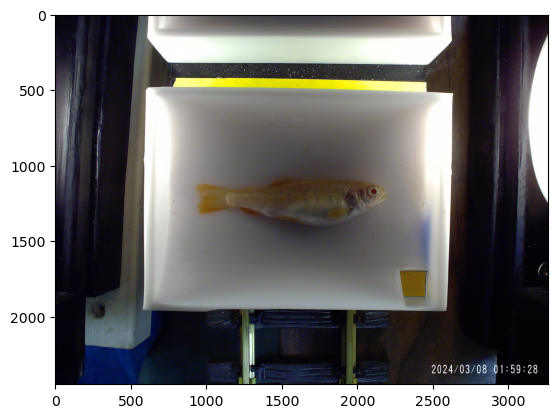

In [6]:
face_bgr_np = cv2.imread(face_path)
face_rgb_np = cv2.cvtColor(face_bgr_np, cv2.COLOR_BGR2RGB)

face_boxes = face_detector.predict(face_rgb_np)[0]

for box in face_boxes:
  box.draw_label(face_rgb_np, "Face")
  box.draw_box(face_rgb_np)
plt.imshow(face_rgb_np)
plt.show()

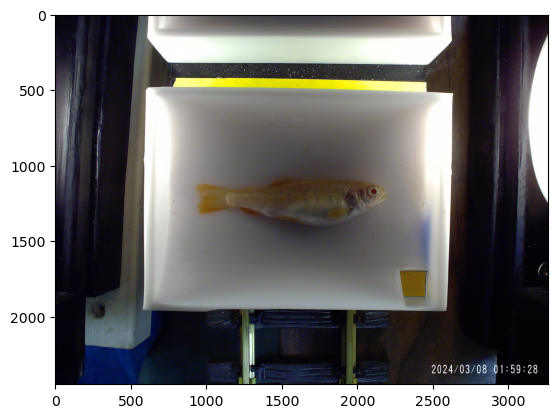

INFO:root:[PROCESSING][CLASSIFICATION] Classification by Full Connected layer for a single detection mask
INFO:root:[PROCESSING][CLASSIFICATION] Classification by embedding for a single detection mask
INFO:root:[PROCESSING][CLASSIFICATION] Append into output classification result by FC - layer


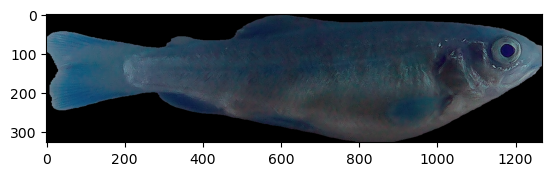

ID: 1
Name: Oncorhynchus kisutch
Species ID: 39200310-e56f-46b4-b348-571fb5267ef1
Distance: 0.492
Accuracy: 26.67%
----------------------------------------
ID: 2
Name: Salmo salar
Species ID: 7d683873-e7e1-4353-973b-7fb96d3d57b2
Distance: 0.528
Accuracy: 20.00%
----------------------------------------
ID: 3
Name: Oncorhynchus mykiss
Species ID: c0ae3480-8f0a-4785-9098-9d8b6b294df9
Distance: 0.280
Accuracy: 20.00%
----------------------------------------
ID: 4
Name: Salvelinus confluentus
Species ID: 286e1083-ed85-4599-8457-69833bb52b54
Distance: 0.268
Accuracy: 13.33%
----------------------------------------
ID: 5
Name: Amia calva
Species ID: 6966eb06-913f-49c2-9fa3-046bdf09347d
Distance: 0.321
Accuracy: 6.67%
----------------------------------------
ID: 6
Name: Gadus morhua
Species ID: 9046fbda-c0ae-4381-b8b1-973b75ed72bb
Distance: 0.245
Accuracy: 6.67%
----------------------------------------
ID: 7
Name: Salvelinus malma
Species ID: 12a632e9-c4f1-4807-b345-9b5ee2640caf
Distance: 0.23

KeyError: 'distance'

In [7]:
fish_bgr_np = cv2.imread(fish_path)
visulize_img_bgr = fish_bgr_np.copy()

visulize_img_rgb = cv2.cvtColor(fish_bgr_np, cv2.COLOR_BGR2RGB)
visulize_img = copy.deepcopy(visulize_img_rgb)


face_boxes = face_detector.predict(visulize_img_rgb)[0]

for box in face_boxes:
  box.draw_label(visulize_img, "Face")
  box.draw_box(visulize_img)
plt.imshow(visulize_img)
plt.show()

boxes = detector.predict(visulize_img_rgb)[0]

for box in boxes:
  cropped_fish_bgr = box.get_mask_BGR()
  cropped_fish_rgb = box.get_mask_RGB()
  segmented_polygons = segmentator.predict(cropped_fish_bgr)[0]

  croped_fish_mask = segmented_polygons.mask_polygon(cropped_fish_rgb)

  segmented_polygons.move_to(box.x1, box.y1)
  segmented_polygons.draw_polygon(visulize_img)

  classification_result = classifier.batch_inference([cropped_fish_bgr])[0]

  label = f"{classification_result[0]['name']} | {round(classification_result[0]['accuracy'], 3)}" if len(classification_result) else "Not Found"
  box.draw_label(visulize_img, label)
  box.draw_box(visulize_img)

  print(50 * "=")
  plt.imshow(croped_fish_mask)
  plt.show()
  print_fish_data(classification_result)
plt.imshow(visulize_img)
plt.show()

# FU

In [ ]:
import time
import cv2

# Image Load
face_bgr_np = img = cv2.imread(face_path)
face_rgb_np = cv2.cvtColor(face_bgr_np, cv2.COLOR_BGR2RGB)

fish_bgr_np = cv2.imread(fish_path)
fish_rgb_np = cv2.cvtColor(fish_bgr_np, cv2.COLOR_BGR2RGB)

times_array = []
for _ in range(3):
  start_time_complex = time.time()
  print(20 * "=")
  start_time = time.time()
  face_boxes = face_detector.predict(face_bgr_np)[0]
  end_time = time.time()
  print(f"Face detection time: {end_time - start_time:.4f} seconds")

  start_time = time.time()
  boxes = detector.predict(fish_bgr_np)[0]
  end_time = time.time()
  print(f"Fish detection time: {end_time - start_time:.4f} seconds")

  # Обработка каждого объекта
  for box in boxes:
      cropped_fish_bgr = box.get_mask_BGR()

      # Segmentation
      start_time = time.time()
      segmented_polygons = segmentator.predict(cropped_fish_bgr)[0]
      end_time = time.time()
      print(f"Segmentation time: {end_time - start_time:.4f} seconds")

      # Classification
      start_time = time.time()
      classification_result = classifier.batch_inference([cropped_fish_bgr])[0]
      end_time = time.time()
      print(f"Classification time: {end_time - start_time:.4f} seconds")
  times_array.append(time.time() - start_time_complex)

print(f"Average time: {sum(times_array)/len(times_array)}")

Face detection time: 0.1803 seconds
Fish detection time: 0.4544 seconds
Segmentation time: 0.4711 seconds
Classification time: 0.2754 seconds
Segmentation time: 0.4623 seconds
Classification time: 0.2520 seconds
Segmentation time: 0.4918 seconds
Classification time: 0.2591 seconds
Segmentation time: 0.4691 seconds
Classification time: 0.2480 seconds
Segmentation time: 0.4677 seconds
Classification time: 0.2490 seconds
Segmentation time: 0.4641 seconds
Classification time: 0.2569 seconds
Segmentation time: 0.4637 seconds
Classification time: 0.2499 seconds
Segmentation time: 0.4614 seconds
Classification time: 0.2566 seconds
Segmentation time: 0.4759 seconds
Classification time: 0.2454 seconds
Face detection time: 0.1666 seconds
Fish detection time: 0.4530 seconds
Segmentation time: 0.4584 seconds
Classification time: 0.3186 seconds
Segmentation time: 0.7134 seconds
Classification time: 0.3680 seconds
Segmentation time: 0.7144 seconds
Classification time: 0.3782 seconds
Segmentation tim

## Face detection time execution test without postprocessing

In [ ]:
BATCH_SIZE = 10
start_time = time.time()
face_detector.model(torch.randn(BATCH_SIZE,3,640,640))
print(f"Mean face detection total time (Batch): {(time.time() - start_time)} seconds")

Mean face detection total time (Batch): 2.254533052444458 seconds


## Fish detection time execution test without postprocessing

In [ ]:
BATCH_SIZE = 1
start_time = time.time()
detector.model(torch.randn(BATCH_SIZE,3,640,640))
print(f"Mean fish detection total time (Batch): {(time.time() - start_time)} seconds")


Mean fish detection total time (Batch): 0.9071292877197266 seconds


## Fish Segmentation time execution test without postprocessing

In [ ]:
BATCH_SIZE = 5
start_time = time.time()
segmentator.model(torch.randn(BATCH_SIZE,3,416,416))
print(f"Fish segmentation total time (Batch): {(time.time() - start_time)} seconds")

Fish segmentation total time (Batch): 6.364283084869385 seconds


## Fish Classification time execution test without postprocessing

In [ ]:
BATCH_SIZE = 5
start_time = time.time()
classifier.model(torch.randn(BATCH_SIZE,3,224,224))
print(f"Fish Classification total time (Batch): {(time.time() - start_time)} seconds")

Fish Classification total time (Batch): 0.8254907131195068 seconds
